In [1]:
# Reference: https://jupyterbook.org/interactive/hiding.html
# Use {hide, remove}-{input, output, cell} tags to hiding content

import sys
import os
if not any(path.endswith('textbook') for path in sys.path):
    sys.path.append(os.path.abspath('../../..'))
from textbook_utils import *

In [28]:
type(3 + 7)

int

In [27]:
7

7

In [29]:
type(3.0 + 7)

float

In [30]:
type((2 + 8) / 5)

float

# Basics of Hypothesis Testing

A hypothesis test can offer support for your model, and it can help formally refute some other understanding of the world. There are four basic steps to hypothesis testing:

1. Set up: You have your data, and you want to test whether a particular model is reasonably consistent with the data. So, you specify a statistic, such as a sample average, fraction of zeros in a sample, or fitted regression coefficient, and compare your data's statistic to what might have been produced under the model.

1. Model: You spell out the model that you want to test as a data generation mechanism, along with an specific assumption about the population, such as its mean, the proportion of zeros, or regression coefficient. The sampling distribution of the statistic under this model is referred to as the null distribution, and the model itself is called the Null hypothesis.

3. Compute: How likely, according to the model in Step 2, is it to get data (and the resulting statistic) at least as extreme as what you actually got in Step 1?  In formal inference, this probability is called the $p$-value. To approximate the $p$-value, we use the computer to generate a large number of random samples from the model and find the fraction of samples that give a value of the statistic at least as extreme as the observed value.
  
4. Interpret: The p-value is used as a measure of surprise.  If the model that you spelled out in Step 2 is believable, how surprised should you be to get the data (and summary statistic) that you actually got?  A moderate sized p-value means that the observed statistic is pretty much what you would expect to get for data generated by the null model.  A tiny p-value raises doubts about the null model: If the model is correct (or approximately correct), then it would be very unusual to get such an extreme value of the test statistic for data generated by the model.  In other words, either the null model is wrong, or else a very unlikely outcome has occurred. Statistical logic says to conclude that the pattern is real, that is, more than just coincidence.  It is then up to you to explain why the data generation process led to such an unusual value. This is when a careful examination of the scope is important. 

Let's make these steps in the testing process more concrete with an example. 

## The Effect of Informal Award on Wikipedia Contributors 

Recall the Wikipedia example from {numref}`Chapter %s <ch:data_scope>`, where a randomly selected set of 200 contributors chosen from among the top 1\% of contributors who were active in the past 30 days on the English-language Wikipedia and who had never receive an informal  "barnstart" award.  These 200 contributors were divided at random into two groups of 100. The contributors in one group, the treatment, were each awarded a barnstar, while no one in the other group was given an award. All 200 contributors were followed for 90 days and their activity on Wikipedia recorded. 

It has been conjectured that informal awards have a reinforcing effect on volunteer work, and this experiment was designed to formally study this conjecture. We will carry out three different tests of this hypothesis, each using a different statistic suggested by our exploration of the data. We begin by reading the data.

In [2]:
wiki = pd.read_csv("data/Wikipedia.csv")
wiki.shape

(200, 2)

In [3]:
wiki.describe()[3:]

,experiment,postproductivity
min,0.0,0.0
25%,0.0,57.5
50%,0.5,250.5
75%,1.0,608.0
max,1.0,2344.0


There are 200 rows in the data frame, one for each contributor. The feature `experiment` is either 0 or 1, depending on whether the contributor was in the control or treatment group, respectively, and `postproductivity` is a count of edits made by the contributor in the 90 days after the treatment. The gap between the quartiles (lower, middle, and upper) suggest the distribution of productivity is highly skewed. We make a histogram to confirm.

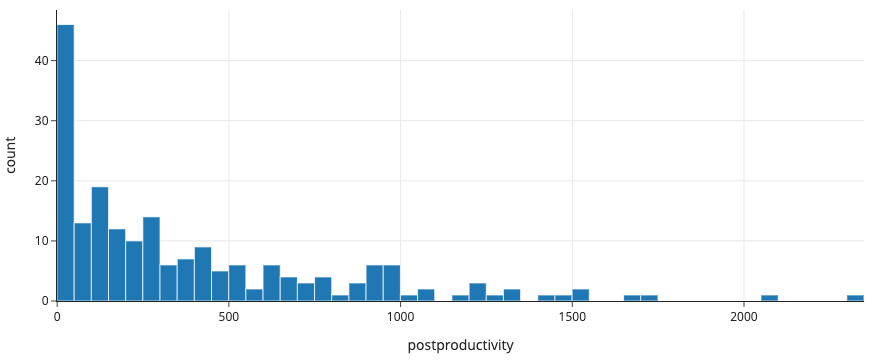

In [4]:
fig = px.histogram(wiki, x='postproductivity', nbins=50,
                      width=350, height=250)

fig

The histogram of productivity is highly skewed, with a spike near zero. Let's compare the median productivity for the two groups.

In [5]:
control = wiki.query('experiment == 0')
treatment = wiki.query('experiment == 1')

print('Median productivity:', wiki.median()[1], 
      '\nMedian productivity in control group: ', control.median()[1],
      '\nMedian productivity in treatment group: ', treatment.median()[1])

Median productivity: 250.5 
Median productivity in control group:  157.5 
Median productivity in treatment group:  369.5


The medians of the two groups are quite different. For a finer comparison of the groups, we examine the quantile-quantile plot of the two sets of sample data (see {numref}`Chapter %s <ch:viz>`). Since the distribution is highly skewed, we have plotted the quantiles on a log scale. And, to handle problems with taking a logarithm of zero, we added one to all the data values. This addition has little impact on the quantiles and distributions since the values range from 0 to 2344.

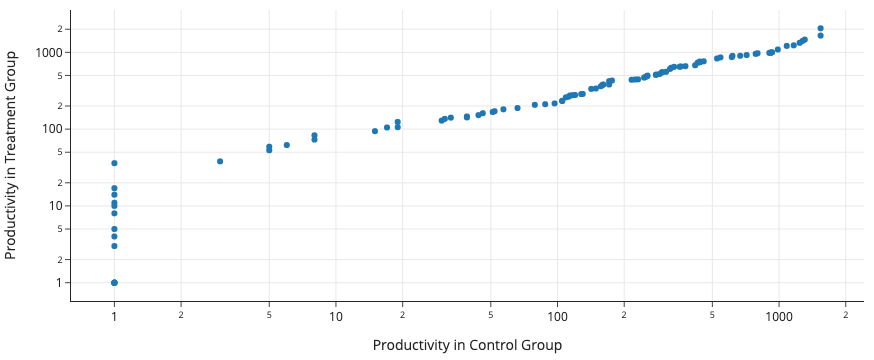

In [6]:
percs = np.arange(1, 100, 1)
percCon = 1 + np.percentile(control['postproductivity'], percs, interpolation='lower')
percTrt = 1 + np.percentile(treatment['postproductivity'], percs, interpolation='lower')
perc_wiki = pd.DataFrame({'percentile': percs, 'control': percCon, 'treatment': percTrt})

fig = px.scatter(perc_wiki, x='control', y='treatment', log_x=True, log_y=True, width=500, height=350,
                 labels={'control': 'Productivity in Control Group',
                         'treatment': 'Productivity in Treatment Group'})
 
fig

With one glaring exception, the quantiles of the two distributions roughly follow a line, which indicates that the distributions are similar in shape. The exception is the number of ones in the first several quantiles for the control group. Let's compare the count of zeros in the two groups (remember we added 1 to all of the values before finding the quantiles).  

In [7]:
countAll = wiki['postproductivity'].value_counts()[0]
countA = control['postproductivity'].value_counts()[0]
countB = treatment['postproductivity'].value_counts()[0]
print('Count of 0-productive members: ', countAll,
      '\nCount in control group: ', countA,
      '\nCount in treatment group: ', countB)

Count of 0-productive members:  19 
Count in control group:  14 
Count in treatment group:  5


There are quite a few more zeros in the control group compared to treatment. 
Our first hypothesis test is simply based on a comparison of the proportion of zeros in the two groups.

## A test for proportions

In all three hypothesis tests that we perform with the Wikipedia data, the model is essentially the same. The model assumes that an informal award has *no* effect on productivity and any difference observed between the treatment and control groups is due to the chance process in assigning contributors to groups. The Null hypothesis is often set up as the status quo to be rejected; that is, we hope to find a surprise. 

In this first test our statistic relates to the zeros observed in the two groups. Specifically, we examine the difference in the proportion of zeros in the groups. 

$$ \hat{p}_{T} - \hat{p}_C,$$

where $\hat{p}_T = \# 0s \textrm{ in treatment} / 100$, and $\hat{p}_C$ is similarly defined for the control group. The Null Hypothesis assumes that this difference is 0, and it's simply the luck of the draw that resulted in so few zeros in the treatment group.   
 

Under the null, the proportion of zeros in the treatment and control groups is the same, and any observed difference is due to the random variation in assignment to treatment/control group. In other word, the 19 contributors who had no productivity in the 90-day period following the treatment, would have behaved exactly the same whether they were assigned to treatment or control. We can represent this null model as an urn with 200 marbles, with 19 of them marked $0$ and $181$ marked with a $1$, and we draw 100 times to select the treatment group. In {numref}`Chapter %s <ch:theory_design>`, we encountered a similar situation with a vaccine trial. There we found that draws from a 0-1 urn followed a named distribution called the hypergeometric, and `numpy` provides a simulator for this model, making it easy to find the p-value.  

In [8]:
sim0s = np.random.hypergeometric(ngood=19, nbad=181, 
                                 nsample=100, size=100000)

We can construct the 100000 statistic values from the counts of 0-productivity elements in the sample.

In [9]:
sim_pT_pC = sim0s/100 - (19-sim0s)/100

Below is an approximation of the sampling distribution for the statistic. 

Text(0.5, 0, 'Difference in proportion of 0-productivity Cases')

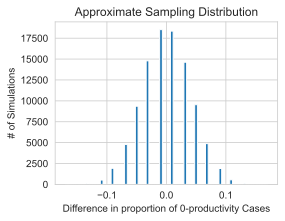

In [10]:
plt.hist(sim_pT_pC, bins=75)
plt.title('Approximate Sampling Distribution')
plt.ylabel('# of Simulations')
plt.xlabel('Difference in proportion of 0-productivity Cases')

Under the null model, the typical proportions of zeros in the two groups are the same, and so the difference in the proportions is close to zero. In our data, we observed a difference of $0.05  - 0.19 = -0.14$. We can approximate the $p$-value, which is the chance of seeing a difference at least as big as -0.14. 

In [11]:
(sim_pT_pC <= (0.05 - 0.14)).sum() / 100000

0.02581

The $p$-value tells us that there's about a  2.5\% chance of observing a negative difference in proportions at least as large as $-0.14$. Is this a surprise? It's small. Before we decide, let's look at a hypothesis test based on the medians of the groups. 

## A test for a difference in medians

We saw earlier that the two groups had quite a bit different median productivity. Under the null, we expect the treatment to have no effect and each contributor's productivity to be unaffected by their receipt of the award. That is, the productivity for a top contributor would be unchanged by the receipt of an informal award. Any difference in the observed medians for the two groups is simply due to the chance assignment to treatment and control.  

Now our statistic is the difference: $median_T - median_C$. This time, our model doesn't reduce to an urn of marbles labeled zero or one. Instead, it is an urn with 200 marbles, each labeled with the productivity of one of the contributors. Again, we draw 100 marbles from the urn to find the treatment group, and the marbles remaining in the urn represent the control group. 

To carry out this simulation, we set up the urn as an array of productivity data. 

In [12]:
urn = wiki[['postproductivity']].to_numpy()

Our statistic is the difference: 

In [13]:
sample_median_dif = np.median(urn[100:]) - np.median(urn[:100])
sample_median_dif

212.0

For our simulation, we simply shuffle the 200 values, and take the first 100 for the treatment group and the next 100 for the control. We write a function to find the difference in  

In [14]:
from numpy.random import default_rng
rng = np.random.default_rng(42)

def median_difference(production, n):
    rng.shuffle(production)
    return (np.median(production[n:]) - np.median(production[:n]))            

We shuffle the marbles in the urn 10000 times, and compute the difference in medians for each shuffle.

In [15]:
median_diff_simulation = [median_difference(urn, 100) for _ in range(10000)] 

Text(0.5, 0, 'Difference in median productivity between treatment and control')

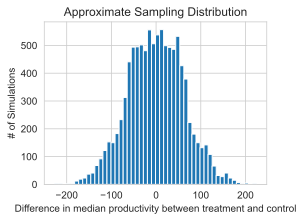

In [16]:
plt.hist(median_diff_simulation, bins=50)
plt.title('Approximate Sampling Distribution')
plt.ylabel('# of Simulations')
plt.xlabel('Difference in median productivity between treatment and control')

As we might expect, the sampling distribution of the difference in medians is centered on 0. This reflects our assumptions of the treatment having no effect. Our observed statistic is quite large (in the negative sense). We use this simulated sampling distribution to find the approximate $p$-value for observing a difference in medians at least as big as ours.

In [17]:
len([elem for elem in median_diff_simulation if elem <= -212]) / 10000

0.0003

This $p$-value is an even bigger surprise than the $p$-value based on the proportion of zeros in the groups. Only about 3 of the 10,000 simulated samples had a difference this large. This test raises doubts about the null model. Statistical logic has us conclude that the pattern is real. How do we interpret this? The experiment was well designed. The 200 contributors were selected at random from the top 1% and then they were divided at random into two groups. These chance processes say that we can rely on the sample of 200 being representative of top contributors, and the treatment and control groups being similar to each other in every way except for the application of the treatment. Given the careful design, we conclude that informal awards have a positive effect on productivity for top contributors.

Such a simulation like the one we just performed, was not practical before today's world of cheap, powerful computers.  An alternative approach, that was developed in the 1950s and 1960s, uses rank statistics. The approach is still used today with highly skewed samples and multiple tests. We describe it next.

## A test based on ranks

The test based on sample medians, is an example of a randomization test. The test works conditionally on the observed data, and considers all possible alternative outcomes based on a different, random assignment. It's especially useful when we have randomized controlled experiments. A clever alternative to the full-blown randomization test, uses the ranks of the data values, rather than the values themselves.  For our experiment, we pool all of the data from treatment and control and order them from smallest to largest. We give the smallest value a rank of 1, the second smallest has rank 2, and so on up to the largest value with a rank of 200. These ranks replace the actual values on the marbles.

The statistic itself is the sum of the ranks on the marbles drawn for the urn. Like with the previous hypothesis tests, under the null, the sum of the ranks for productivity for the two groups should be the same, namely $(200 \times 201)/4 = 10050$ (We show why in the exercises). Any difference is due to the chance process in assignment to the groups.

We use the `rankdata` method to rank the 200 values and compute the sum of ranks in the treatment group.

In [18]:
from scipy.stats import rankdata
ranks = rankdata(wiki['postproductivity'], 'average')
sum(ranks[100:])

11368.0

The ranks in the treatment group are higher than expected, and we can use simulation to find the sampling distribution for the rank-sum statistic. Again, we write a helper function to shuffle the data (ranks, actually) and sum the first 100. 

In [19]:
def rank_sum(ranks, n):
    rng.shuffle(ranks)
    return np.sum(ranks[n:])      

rng = np.random.default_rng(42)
rank_sum_simulation = [rank_sum(ranks, 100) for _ in range(100000)] 

Text(0.5, 0, 'Rank Sum for treatment')

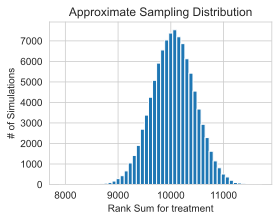

In [20]:
plt.hist(rank_sum_simulation, bins=50)
plt.title('Approximate Sampling Distribution')
plt.ylabel('# of Simulations')
plt.xlabel('Rank Sum for treatment')

The simulated sampling distribution gives us an approximate $p$-value.

In [21]:
len([elem for elem in rank_sum_simulation if elem >= 11368]) / 100000

0.00052

Again, a big surprise. Under the null, the chance of seeing a rank-sum at least as large as ours is about 6 in 10,000. All three tests have demonstrated how to go about carrying out a hypothesis test. The key is to specify the model and statistic so that a simulation can provide an approximate $p$-value. Another important step is to properly interpret the results. If the data have not come from a well-designed study, then the conclusion may still be that the difference is real, but the cause of the difference is another matter. Some times that's all we need to say - the data do not behave like a random sample from this model.    

We wrap up this section by noting that the sampling distributions for all three tests are roughly symmetric and normal in shape. But, the sampling distribution for the rank-sum statistic is nearly perfect in its normal shape. This is because the ranks maintain order, but remove skewness from the data, so the sum of random ranks has an approximate normal distribution for sums of ranks for samples of as few as 20 to 30 values. While, we have simply simulated the approximate sampling distribution of the rank-sum and not used this normal property of the sampling distribution, it was originally designed as a statistics because of this useful property, and today, when conducting hundreds and thousands of A/B tests, many of which have skewed empirical distributions, tests based on ranks are still popular.

The simulations we carried out in this section, were possible because our null model completely specified the chance mechanism for the data. That is often not the case, and the next section introduces an approach to approximate the model using the data.